In [1]:
import torch
import torch.utils.data
import glob
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.nn import functional as F
import time
from torch.nn.utils import weight_norm

In [2]:
seed = 1995
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
Fs = 100000

In [4]:
train_data_torch = torch.load('../data/databases/train_data_torch_main.pt')
train_targets_torch = torch.load('../data/databases/train_targets_torch_main.pt')

test_data_torch = torch.load('../data/databases/test_data_torch_main.pt')
test_targets_torch = torch.load('../data/databases/test_targets_torch_main.pt')

In [5]:
print('Dim Train Data: ', train_data_torch.shape)
print('Dim Train Targets: ', train_targets_torch.shape)
print('Dim Test Data: ', test_data_torch.shape)
print('Dim Train Targets: ', test_targets_torch.shape)

Dim Train Data:  torch.Size([16136, 1, 35000])
Dim Train Targets:  torch.Size([16136])
Dim Test Data:  torch.Size([4042, 1, 35000])
Dim Train Targets:  torch.Size([4042])


In [6]:
numChannels = 1
numClasses = 3

In [7]:
import matplotlib.pyplot as plt
i = 100

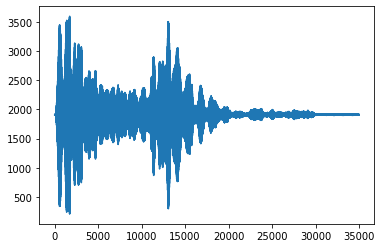

In [8]:
plt.plot(train_data_torch.narrow(0, i, 1).narrow(1, 0, 1).view(-1).numpy())

# This is the formula for computing the size of the output of every layer

$$L_{out} = \frac{L_{in}- Kernel_{size}}{stride}+1$$

# Here there's and example: 
$input size = 1 * 20'000 * 4 $

after the first convolution:
$output = \frac{20000-5000}{5}+1 = 3001$
and the channels go from the initial 4 to the specified 32

after the second convolution:
$output = \frac{3001-2002}{1}+1 = 1000$
and the channels go from 32 to 64

after the last convolution:
$output = \frac{1000-1000}{1}+1 = 1$
and the channels go from 64 to 5 (as the number of classes!!!)




In [9]:
(35000-5000)/2+1

15001.0

In [10]:
(15001-5000)/2+1

5001.5

In [11]:
(5001-4500)/2+1

251.5

In [12]:
KERNEL_SIZE = 128
POOL_FACT = 2
STRIDE_FACT = KERNEL_SIZE // 4
CHANNEL_COUNT = 32
use_avg_pool = True
model = torch.nn.Sequential() 
output_dim = 35000//2
model.append(torch.nn.Conv1d(in_channels = 1, out_channels = CHANNEL_COUNT, kernel_size = KERNEL_SIZE, stride=STRIDE_FACT)) #16x16896 - 512 + 1 
output_dim = (output_dim - KERNEL_SIZE) // STRIDE_FACT + 1
model.append(torch.nn.ReLU()) 
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Conv1d(in_channels = CHANNEL_COUNT, out_channels=CHANNEL_COUNT, kernel_size=KERNEL_SIZE // 2, stride=STRIDE_FACT // 2)) #16x7681
output_dim = (output_dim - KERNEL_SIZE // 2) // (STRIDE_FACT // 2)+ 1
model.append(torch.nn.ReLU())
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Flatten())
model.append(torch.nn.Linear(in_features = int(output_dim) * CHANNEL_COUNT, out_features = 9))
model.append(torch.nn.ReLU())
model.append(torch.nn.Linear(in_features = 9, out_features = 3))

Sequential(
  (0): Conv1d(1, 32, kernel_size=(128,), stride=(32,))
  (1): ReLU()
  (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (3): Conv1d(32, 32, kernel_size=(64,), stride=(16,))
  (4): ReLU()
  (5): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=192, out_features=9, bias=True)
  (8): ReLU()
  (9): Linear(in_features=9, out_features=3, bias=True)
)

In [13]:
#model, criterion = fastCNN(), nn.CrossEntropyLoss()

In [14]:
criterion = torch.nn.CrossEntropyLoss()

In [15]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
count_parameters(model)

71463

In [17]:
def compute_nb_errors(model, testing_generator):
    nb_errors=0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testing_generator:
            if (torch.cuda.is_available()):
                # Transfer to GPU
                local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
            outputTest = model(local_batch)
            predicted_classes = outputTest.max(1)[1]
            nb_errors += (predicted_classes != local_labels).long().sum()

    return nb_errors

In [18]:
if (torch.cuda.is_available()):
    model = model.cuda()

In [19]:
train_input = train_data_torch.view(train_data_torch.size(0), numChannels, -1).float()
train_target = train_targets_torch.long().view(-1)
test_input = test_data_torch.view(test_data_torch.size(0), numChannels, -1).float()
test_target = test_targets_torch.long().view(-1)

In [20]:
train_input.shape

torch.Size([16136, 1, 35000])

In [21]:
train_input = np.abs(torch.fft.fft(train_input)).narrow(2,1,train_input.shape[-1]//2)
test_input = np.abs(torch.fft.fft(test_input)).narrow(2,1,test_input.shape[-1]//2)

In [22]:
train_input = train_input/torch.max(train_input,2,keepdim=True)[0]
test_input = test_input/torch.max(test_input,2,keepdim=True)[0]

In [23]:
train_input.shape

torch.Size([16136, 1, 17500])

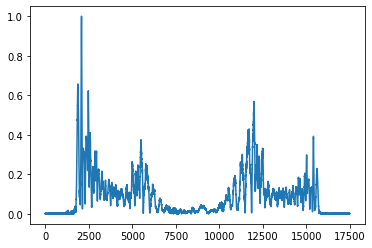

In [24]:
plt.plot(train_input.narrow(0, i, 1).narrow(1, 0, 1).view(-1).numpy())

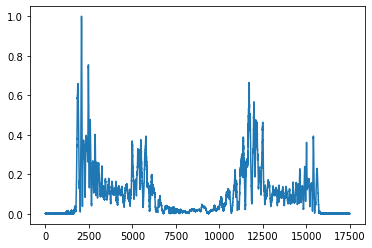

In [25]:
plt.plot(test_input.narrow(0, i, 1).narrow(1, 0, 1).view(-1).numpy())

In [26]:
train_input.narrow(0, 0, 2).shape

torch.Size([2, 1, 17500])

In [27]:
out = model(train_input.narrow(0, 0, 2).cuda())
out.shape

torch.Size([2, 3])

In [28]:
lr = 3e-3

In [29]:
optimizer = optim.Adam(model.parameters(), lr = lr)
nb_epochs = 150
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.2, patience = 30)

In [30]:
class errorsTable():
    def __init__(self):
        self.accuracyMatr = np.zeros((numClasses,numClasses))
    def newEntry(self,predictions,groundTruths):
        for pred,tru in zip(predictions,groundTruths):
            #print(pred, tru)
            self.accuracyMatr[pred,tru]+=1
    def getStats(self):
        #print(self.accuracyMatr)
        numEntry = np.sum(self.accuracyMatr,0)
        resultMatr = self.accuracyMatr/numEntry
        return resultMatr

In [31]:
np.set_printoptions(precision=2, suppress=True)

In [32]:
batch_size_train = 5000
batch_size_test = 1000

In [33]:
#torch.backends.cudnn.enabled = False

In [34]:
training_set = torch.utils.data.TensorDataset(train_input, train_target)
testing_set = torch.utils.data.TensorDataset(test_input, test_target)

In [35]:
# Generators
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, num_workers=0,
                                                shuffle=True, drop_last=True)
testing_generator = torch.utils.data.DataLoader(testing_set, batch_size=batch_size_test, num_workers=0,
                                                 shuffle=False, drop_last=False)

In [36]:
loss_train = []
loss_test = []

t = time.time()
for k in range (nb_epochs):
    
    # Create a new error table
    accuracyTRAIN = errorsTable()
    accuracyTEST = errorsTable()
    print('Epoch: ', k)
    model.train()

    lossValue = 0
    for local_batch, local_labels in training_generator:
        if (torch.cuda.is_available()):
            # Transfer to GPU
            local_batch, local_labels = local_batch.cuda(), local_labels.cuda()       
        model.zero_grad()
        output = model(local_batch)
        accuracyTRAIN.newEntry(output.max(1)[1], local_labels)
        loss = criterion(output, local_labels)
        lossValue += loss.item()*local_batch.size(0)
        loss.backward()
        optimizer.step()
    scheduler.step(lossValue/train_input.size(0))
    print('Loss is ', lossValue/train_input.size(0))
    loss_train.append(lossValue/train_input.size(0))    
    ################################################################    
    model.eval()
    lossValue = 0 
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testing_generator:
            if (torch.cuda.is_available()):
                # Transfer to GPU
                local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
            outputTest = model(local_batch)
            accuracyTEST.newEntry(outputTest.max(1)[1], local_labels)
            lossTest = criterion(outputTest, local_labels)
            lossValue += lossTest.item()*local_batch.size(0)
    print('Loss TEST is ', lossValue/test_input.size(0))
    loss_test.append(lossValue/test_input.size(0))
    print("")
    print("The accuracy in TEST is: ")
    print("  1      2      3   ")
    print(accuracyTEST.getStats())
    print("The accuracy in TRAIN is: ")
    print("  1      2      3   ")
    print(accuracyTRAIN.getStats())
    print("----------------------")
    if k%10 == 0:
        #nb_test_errors = compute_nb_errors(model, test_input, test_target, batch_size_test)

        #print(k, ': Test accuracy Net {:0.2f}%% {:d}/{:d}'.format(100-(100 * nb_test_errors) / test_input.size(0),
                                                     #nb_test_errors, test_input.size(0)))
        

        #nb_train_errors = compute_nb_errors(model, train_input, train_target, batch_size_train)

        #print(k, ': Train accuracy Net {:0.2f}%% {:d}/{:d}'.format(100-(100 * nb_train_errors) / train_input.size(0),
                                                          #nb_train_errors, train_input.size(0)))
        print("Hey! Ten epochs are passed! We are getting older")
        
        


nb_test_errors = compute_nb_errors(model, testing_generator)  
print('Final Test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                  nb_test_errors, test_input.size(0)))

elapsed = time.time() - t
print(elapsed)

Epoch:  0
Loss is  0.996882844869607
Loss TEST is  1.065108737752085

The accuracy in TEST is: 
  1      2      3   
[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
The accuracy in TRAIN is: 
  1      2      3   
[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
----------------------
Hey! Ten epochs are passed! We are getting older
Epoch:  1
Loss is  0.9895548276163648
Loss TEST is  1.06037344547972

The accuracy in TEST is: 
  1      2      3   
[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
The accuracy in TRAIN is: 
  1      2      3   
[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
----------------------
Epoch:  2
Loss is  0.9835231079580055
Loss TEST is  1.0547322201174358

The accuracy in TEST is: 
  1      2      3   
[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
The accuracy in TRAIN is: 
  1      2      3   
[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
----------------------
Epoch:  3
Loss is  0.9778004193223226
Loss TEST is  1.0451534246230467

The accuracy in TEST is: 
  1      2      3   
[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
The acc

Loss is  0.35254219172907514
Loss TEST is  0.3744072021381033

The accuracy in TEST is: 
  1      2      3   
[[0.77 0.   0.  ]
 [0.1  0.93 0.04]
 [0.13 0.07 0.96]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.8  0.   0.01]
 [0.07 0.94 0.04]
 [0.13 0.06 0.95]]
----------------------
Epoch:  29
Loss is  0.34100904757868966
Loss TEST is  0.36317699439805196

The accuracy in TEST is: 
  1      2      3   
[[0.77 0.   0.  ]
 [0.1  0.99 0.04]
 [0.13 0.01 0.96]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.8  0.   0.01]
 [0.07 0.95 0.04]
 [0.13 0.05 0.96]]
----------------------
Epoch:  30
Loss is  0.3325548272323183
Loss TEST is  0.34615439191305775

The accuracy in TEST is: 
  1      2      3   
[[0.81 0.   0.  ]
 [0.05 0.96 0.04]
 [0.13 0.04 0.96]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.79 0.   0.  ]
 [0.08 0.97 0.04]
 [0.13 0.03 0.96]]
----------------------
Hey! Ten epochs are passed! We are getting older
Epoch:  31
Loss is  0.3180701062120183
Loss TEST is  0.

Loss is  0.22465546454275725
Loss TEST is  0.26989638099777763

The accuracy in TEST is: 
  1      2      3   
[[0.95 0.   0.09]
 [0.05 1.   0.19]
 [0.   0.   0.72]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.88 0.   0.07]
 [0.02 0.92 0.03]
 [0.1  0.08 0.9 ]]
----------------------
Epoch:  56
Loss is  0.2582111092534583
Loss TEST is  0.15511480815808176

The accuracy in TEST is: 
  1      2      3   
[[0.98 0.   0.07]
 [0.02 1.   0.04]
 [0.01 0.   0.9 ]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.88 0.05 0.06]
 [0.04 0.95 0.09]
 [0.08 0.   0.84]]
----------------------
Epoch:  57
Loss is  0.2062394217683587
Loss TEST is  0.3308113046886306

The accuracy in TEST is: 
  1      2      3   
[[0.79 0.   0.06]
 [0.07 1.   0.04]
 [0.14 0.   0.9 ]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.97 0.02 0.14]
 [0.02 0.98 0.03]
 [0.   0.   0.83]]
----------------------
Epoch:  58
Loss is  0.25208462279033234
Loss TEST is  0.2606397917782653

The accuracy in TEST is: 
  1  

Loss is  0.06761293845361097
Loss TEST is  0.07342090729010217

The accuracy in TEST is: 
  1      2      3   
[[0.99 0.   0.  ]
 [0.   1.   0.02]
 [0.01 0.   0.98]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.99 0.   0.  ]
 [0.   1.   0.02]
 [0.01 0.   0.98]]
----------------------
Epoch:  83
Loss is  0.06610931654081642
Loss TEST is  0.07127558946506272

The accuracy in TEST is: 
  1      2      3   
[[0.99 0.   0.  ]
 [0.   1.   0.02]
 [0.01 0.   0.98]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.99 0.   0.  ]
 [0.   1.   0.02]
 [0.01 0.   0.98]]
----------------------
Epoch:  84
Loss is  0.06451186053103956
Loss TEST is  0.07013161885213404

The accuracy in TEST is: 
  1      2      3   
[[0.99 0.   0.  ]
 [0.   1.   0.02]
 [0.01 0.   0.98]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.99 0.   0.  ]
 [0.   1.   0.02]
 [0.01 0.   0.98]]
----------------------
Epoch:  85
Loss is  0.06235994321945639
Loss TEST is  0.06776806722473001

The accuracy in TEST is: 
 

Loss is  0.03740014383697723
Loss TEST is  0.0413475602179515

The accuracy in TEST is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
The accuracy in TRAIN is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
----------------------
Epoch:  110
Loss is  0.036054886009472105
Loss TEST is  0.04115528207620673

The accuracy in TEST is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
The accuracy in TRAIN is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
----------------------
Hey! Ten epochs are passed! We are getting older
Epoch:  111
Loss is  0.035884971584964044
Loss TEST is  0.04052406035544317

The accuracy in TEST is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
The accuracy in TRAIN is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
----------------------
Epoch:  112
Loss is  0.035133026147803344
Loss TES

Loss is  0.025365462625490654
Loss TEST is  0.02862574093740568

The accuracy in TEST is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
The accuracy in TRAIN is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
----------------------
Epoch:  137
Loss is  0.02470766180312657
Loss TEST is  0.02832188563331969

The accuracy in TEST is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
The accuracy in TRAIN is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
----------------------
Epoch:  138
Loss is  0.024766190948096845
Loss TEST is  0.027882646616292084

The accuracy in TEST is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
The accuracy in TRAIN is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]
----------------------
Epoch:  139
Loss is  0.024246744858632006
Loss TEST is  0.027488924504867406

The accuracy in TES

In [37]:
accuracyTEST = errorsTable()

model.eval()
lossValue = 0 
with torch.set_grad_enabled(False):
    for local_batch, local_labels in testing_generator:
        if (torch.cuda.is_available()):
            # Transfer to GPU
            local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
        outputTest = model(local_batch)
        accuracyTEST.newEntry(outputTest.max(1)[1], local_labels)
        lossTest = criterion(outputTest, local_labels)
        lossValue += lossTest.item()*local_batch.size(0)
print('Loss TEST is ', lossValue/test_input.size(0))

print("")
print("The accuracy in TEST is: ")
print("  1      2      3   ")
print(accuracyTEST.getStats())

Loss TEST is  0.023849069677709885

The accuracy in TEST is: 
  1      2      3   
[[1.   0.   0.  ]
 [0.   1.   0.02]
 [0.   0.   0.98]]


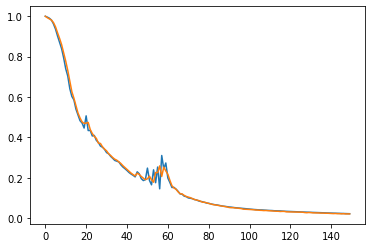

In [38]:
plt.figure()
plt.plot(np.array(loss_test)/max(loss_test))
plt.plot(np.array(loss_train)/max(loss_train))

In [39]:
torch.save(model, '../Models/model_main_another_FFT')